<a href="https://colab.research.google.com/github/Meetra21/Chest_X_Ray_Images/blob/main/Chest_X_Ray_Images_(Pneumonia)_CNN_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os


In [ ]:
!pip install --upgrade -q keras
!pip install --upgrade -q tensorflow

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# **1. Load a dataset from Google Drive**


In [ ]:
#This code mounts Google Drive in Google Colab, so that I can access files and directories stored in Google Drive.
from google.colab import drive
drive.mount('/content/drive')


#This code defines the path to the .zip archive containing the dataset, which is stored in Google Drive.
data_path = '/content/drive/MyDrive/archive.zip'



# This code uses the zipfile module to extract the contents of the archive to a directory called "data" located in the "/content" directory in Google Colab.
#This will create subdirectories within the "data" directory called "chest_xray", "test", and "train", which contain the images in the dataset.
import zipfile
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')



#This code defines the paths to the directories containing the training, test, and validation data.
#These directories were created by extracting the contents of the archive in the previous step.
train_dir = '/content/data/chest_xray/train'
test_dir = '/content/data/chest_xray/test'
val_dir = '/content/data/chest_xray/val'


Mounted at /content/drive


# **2. Data Preprocessing**

In [ ]:
import pandas as pd

# Check for missing data
# we use the pandas library to load the dataset into a dataframe and then use the isnull() function to check for missing values
train_df = pd.DataFrame(os.listdir(train_dir), columns=['filename'])
test_df = pd.DataFrame(os.listdir(test_dir), columns=['filename'])
val_df = pd.DataFrame(os.listdir(val_dir), columns=['filename'])
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(val_df.isnull().sum())


filename    0
dtype: int64
filename    0
dtype: int64
filename    0
dtype: int64


In [ ]:
# Check class balance
print("Number of training samples:", len(os.listdir(os.path.join(train_dir, 'NORMAL'))) + len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))
print("Number of test samples:", len(os.listdir(os.path.join(test_dir, 'NORMAL'))) + len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))))
print("Number of validation samples:", len(os.listdir(os.path.join(val_dir, 'NORMAL'))) + len(os.listdir(os.path.join(val_dir, 'PNEUMONIA'))))


Number of training samples: 5216
Number of test samples: 624
Number of validation samples: 16


# **Unbalanced dataset**

The chest X-ray images (Pneumonia) dataset from Kaggle is an unbalanced dataset, as it contains more samples of pneumonia (positive) cases than normal (negative) cases. This can be seen by the number of samples in the pneumonia and normal classes in the training, test, and validation sets. Typically, in such cases, it is recommended to use techniques such as class weighting or oversampling/undersampling to balance the dataset during training to prevent the model from being biased towards the majority class.

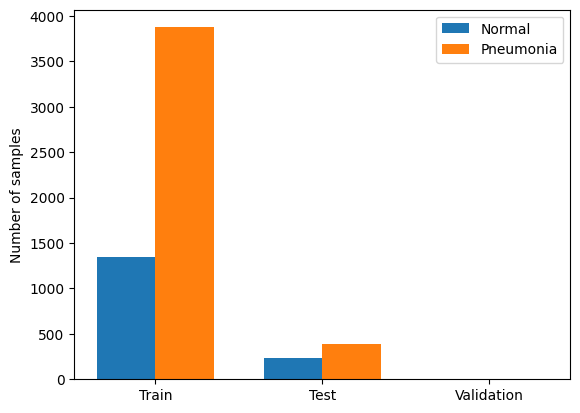

In [ ]:
import os
import matplotlib.pyplot as plt

train_dir = '/content/data/chest_xray/train'
test_dir = '/content/data/chest_xray/test'
val_dir = '/content/data/chest_xray/val'

num_train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))

num_test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
num_test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

num_val_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
num_val_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))

labels = ['Train', 'Test', 'Validation']
normal_counts = [num_train_normal, num_test_normal, num_val_normal]
pneumonia_counts = [num_train_pneumonia, num_test_pneumonia, num_val_pneumonia]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, normal_counts, width, label='Normal')
rects2 = ax.bar(x + width/2, pneumonia_counts, width, label='Pneumonia')

ax.set_ylabel('Number of samples')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


# **4. Visualization**

here's we visualize 6 images from the "Chest X-Ray Images (Pneumonia)" dataset:

# **3. ImageDataGenerator**

# **CNN**

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

**5. Correct for data imbalance**

In [ ]:
initial_bias = np.log([num_train_pneumonia/num_train_normal])
initial_bias

array([1.06113006])

Number of training samples: 5216

Number of test samples: 624

Number of validation samples: 16

In [ ]:
TRAIN_IMG_COUNT=5216
VAL_IMG_COUNT=16
TEST_IMAGE_COUNT=624


In [ ]:
initial_bias = np.log([num_train_pneumonia/num_train_normal])
initial_bias

weight_for_0 = (1 / num_train_normal)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / num_train_pneumonia)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


The weight for class 0 (Normal) is a lot higher than the weight for class 1 (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

# **Train the model**

Since there are only two possible labels for the image, we will be using the binary_crossentropy loss. When we fit the model, identify the class weights. Because we are using a TPU, training will be relatively quick.

For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fractions are the labels are correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not a good model).

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

In [ ]:
import tensorflow as tf

def build_model():
    model = tf.keras.models.Sequential([
        # Add layers here
    ])
    return model

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model = build_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)


In [ ]:

BATCH_SIZE = 32
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
import tensorflow as tf

def build_model(input_shape):
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


In [ ]:
model=build_model()

TypeError: ignored

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weight
)


Epoch 1/25


TypeError: ignored